In [29]:
import numpy as np
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
import torch
np.set_printoptions(precision=6)
import torch.linalg as LA
# initialize variables
N = 8
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array  

In [6]:
B = 0.1  # Initial B value 
B_not = 20

In [7]:
# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')

J_value = 1
J_matrix_alpha =  1 # NEED TO BE CHANGED 
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [8]:
# # spin glass case 
# J_matrix = np.zeros((N, N), dtype='float64')
# for i in range(N):
#     for j in range(N):
#         if j >= (i + 1):
#             J_matrix[i][j] = np.random.uniform(-1,1)

In [9]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis 

for n in range(Q):  # n is an unused index
    
    # couple_num_list would be my result for each state we loop
    
    if len(loop_state_list)!=0: # loop for couple number for one state
                
        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)
        
        for m in range(Q): # loop for spin and spatial for all states inside the couple number list
            
            if m==0:
                
                couple_num_list_old =couple_num_list
                
                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection 
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # # spatial reflection 
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)
                    
                    # remove the repeated element 
                    couple_num_list = np.unique(couple_num_list)
            else:
                
                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first 
                    couple_num_list_old =couple_num_list
                    
                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection 
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)
                        
                        
                        # # spatial reflection 
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)
                        
                        # remove the repeated element 
                        couple_num_list = np.unique(couple_num_list)
                        
        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())
        
        # remove the ones already found 
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

In [10]:
from scipy.sparse import coo_matrix

# Initialize H matrix
couple_dimen = len(couple_state_matrix)

# Initialize lists to store non-zero values and corresponding indices for HA_matrix and HB_matrix
HA_row_indices = [] # row is col index
HA_values = []
HB_row_indices = []
HB_col_indices = []
HB_values = []

# Loop each basis to fill in the diagonal elements for HA matrix 
for i in range(couple_dimen):
    state_array = np.array(couple_state_matrix[i])
    normalization = len(state_array)
    e_tot = 0
    for j in range(len(state_array)):
        state = D2B(state_array[j])
        for k in range(N):
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1
        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot += e_temp
    HA_row_indices.append(i)
    HA_values.append(e_tot / normalization)

# Generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen, Q))
for i in range(couple_dimen):
    state_array = np.array(couple_state_matrix[i])
    normalization = np.sqrt(len(state_array))
    for j in state_array:
        vector_form_basis_matrix[i][j] = 1
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i] / normalization

# Loop each basis to fill in HB matrix 
for i in range(couple_dimen):
    state_array = np.array(couple_state_matrix[i])
    normalization = np.sqrt(len(state_array))
    result_num_list = np.array([], dtype=int)
    for k in range(len(state_array)):
        spin = D2B(state_array[k])
        for j in range(N):
            if spin[j] == 1:
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list, new_num)
                spin[j] = 1
            else:
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list, new_num)
                spin[j] = 0
    
    vector_final_state = np.zeros(Q)
    for j in result_num_list:
        vector_final_state[j] += 1
        
    vector_final_state = vector_final_state / normalization
    
    for j in range(couple_dimen):
        dot_product = np.dot(vector_final_state, vector_form_basis_matrix[j])
        if dot_product != 0:  # Only store non-zero values for sparsity
            HB_row_indices.append(i)
            HB_col_indices.append(j)
            HB_values.append(dot_product)

# Create sparse matrices using COO format
HA_matrix = coo_matrix((HA_values, (HA_row_indices, HA_row_indices)), shape=(couple_dimen, couple_dimen))
HB_matrix = coo_matrix((HB_values, (HB_row_indices, HB_col_indices)), shape=(couple_dimen, couple_dimen))


In [12]:
from scipy.sparse.linalg import eigsh
from scipy import sparse
# start looping for different B value 
dB=0.01 # 
B_value_list = np.arange(B,B_not,dB) # the biggest value of B, change the sign if we change FM TO AFM 

delta_e_list = []
for B_value in B_value_list:
    result = sparse.linalg.eigsh(HA_matrix+B_value*HB_matrix,k=2, which='SA',return_eigenvectors=False)
    #print(delta_enengy)
    delta_e_list.append(result[0] -result[1]) 

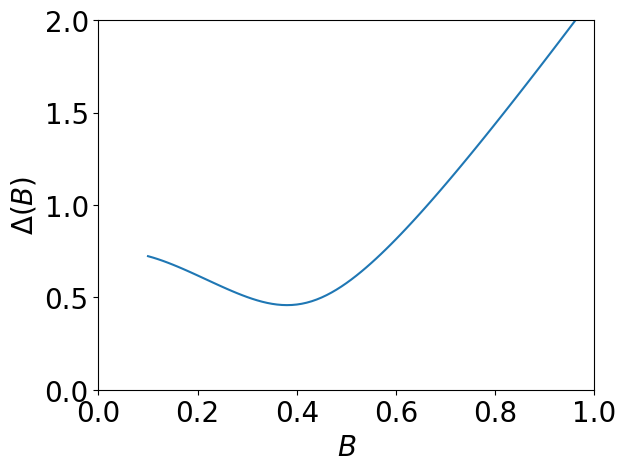

In [30]:
fig, ax = plt.subplots()
ax.plot(B_value_list,delta_e_list)
# ax.plot(test_x,test_y,'black')
ax.set(xlabel=r'$B$', ylabel=r'$\Delta(B)$')
# Increase the font size of the labels
ax.tick_params(axis='both', labelsize=20)
# Set the font size for the axis labels
label_size =20
ax.xaxis.label.set_fontsize(label_size)  # Adjust the font size for the x-axis label
ax.yaxis.label.set_fontsize(label_size)  # Adjust the font size for the y-axis label


ax.set_xlim(0,1)
ax.set_ylim(0,2)

# plot B critical 
# plt.vlines(0.42, 0, 6, color='blue',ls='--')
# plt.vlines(0.45, 0, 6, color='black',ls='--')

# plt.text(0.4,3,'B_critical',size=20,color = 'red')

# latex_text = r'$B_{critical} =0.38$'
# ax.text(0.9, 4.5, latex_text, fontsize=22, ha='center', va='center',color ='red')

plt.savefig('B vs energy gap',bbox_inches='tight')
plt.show()

In [31]:
# just to double name some variable so can be lazy with editing code
delta_e_list = np.array(delta_e_list)
plot_B_total_list = np.array(B_value_list)
plot_de_total_list =delta_e_list

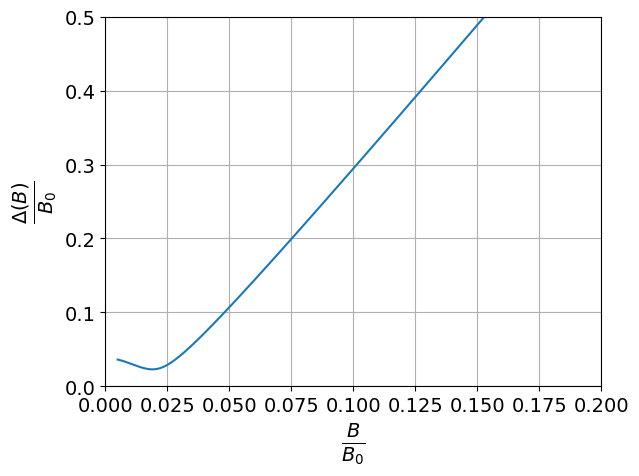

In [32]:
fig, ax = plt.subplots()
ax.plot(plot_B_total_list/B_not, (plot_de_total_list.real)/B_not)
ax.set(xlabel=r'$\frac{B}{B_0}$', ylabel=r'$\frac{\Delta(B)}{B_0}$')
# Increase the font size of the labels
ax.tick_params(axis='both', labelsize=14)
# Set the font size for the axis labels
label_size =20
ax.xaxis.label.set_fontsize(label_size)  # Adjust the font size for the x-axis label
ax.yaxis.label.set_fontsize(label_size)  # Adjust the font size for the y-axis label

ax.set_xlim(0,0.2)
ax.set_ylim(0,0.5)
ax.grid()
plt.show()

In [33]:
print('critical B value = ',plot_B_total_list[np.argmin(plot_de_total_list.real)])
print('critical delta energy value = ',np.min(plot_de_total_list.real))

critical B value =  0.3799999999999999
critical delta energy value =  0.45778596870081234


In [34]:
# calculate t_f , total ramp time, set gamma to be 1
gamma = 1

#from scipy.integrate import simps
one_over_delta_square = pow(1/ delta_e_list,2)
#t_f = gamma * simps(B_total_list, one_over_delta_square)
t_f = gamma * np.trapz(one_over_delta_square,x= B_value_list)
print('t_f is ', t_f)

t_f is  1.9724152563613664


In [35]:
# create reverse B field and de list to calcualte t_c from B_not
B_total_list_reversed = B_value_list[::-1]
B_integrate = np.array([B_total_list_reversed[0]])
one_over_delta_square_reversed = one_over_delta_square[::-1]
one_over_delta_square_integrate = np.array([one_over_delta_square_reversed[0]])

In [36]:
t_c_list = []
for i in range(1,len(B_total_list_reversed)):
    B_integrate = np.append(B_integrate,B_total_list_reversed[i])
    one_over_delta_square_integrate =  np.append(one_over_delta_square_integrate,one_over_delta_square_reversed[i])
    t_c = gamma * np.trapz(one_over_delta_square_integrate,x= B_integrate)
    t_c_list.append(t_c)

t_c_list = -np.array(t_c_list)
t_c_list_unit = t_c_list /t_f # negative sign is to put time into postive or we can change the integral limit before

In [37]:
# becauase len(t_c_list) is one less than len(B_total_list_reversed) 
# I created a new list with old B field range but len(t_c_list) numbere of points 

plot_final_B = np.linspace(np.amin(B_value_list),np.amax(B_value_list) , num=len(t_c_list), retstep=False) 
plot_final_B = plot_final_B[::-1]

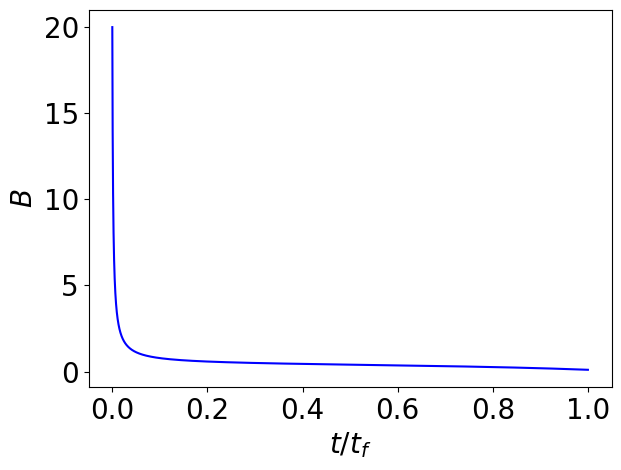

In [38]:
plt.plot(t_c_list/t_f,plot_final_B,color='blue')
plt.xlabel(r'$t/t_{f}$',size=20)
plt.ylabel('$B$',size=20)
plt.tick_params(axis='both', which='both', labelsize=20)  # You can adjust the labelsize as needed
# Save the figure to a file (e.g., PNG format)
# Set tight axis limits
plt.tight_layout()

# Save the figure with tight axis limits to a file (e.g., PNG format)
# plt.savefig("B_field.png", bbox_inches='tight')

In [39]:
# 

In [40]:
# save B field data
import pandas
df = pandas.DataFrame(data={"time": t_c_list, "B": plot_final_B})
df.to_csv(f"./B_profile_N={N}_a={J_matrix_alpha}_B_start={B_not}_B_0={B}.csv", sep=',',index=False)

In [41]:
# read B field file 
time_and_B_data = pandas.read_csv(f"B_profile_N={N}_a={J_matrix_alpha}_B_start={B_not}_B_0={B}.csv")
time_list = time_and_B_data['time'].to_numpy()
B_list = time_and_B_data['B'].to_numpy()
number_of_layers = 100

bi = Akima1DInterpolator(time_list, B_list)
t_data_smooth = np.linspace(min(time_list), max(time_list),number_of_layers)# Number of steps to take for time evolution 
B_data_smooth = bi(t_data_smooth)
print( 'number of layers is', number_of_layers)

number of layers is 100


In [42]:
B_data_smooth

array([19.99    ,  3.284836,  2.00608 ,  1.526475,  1.272446,  1.113901,
        1.004845,  0.924819,  0.863316,  0.814373,  0.774352,  0.740902,
        0.712436,  0.687846,  0.666325,  0.647282,  0.630267,  0.614934,
        0.601011,  0.588286,  0.576578,  0.565748,  0.555679,  0.546275,
        0.537452,  0.529142,  0.521281,  0.513828,  0.506737,  0.499962,
        0.493475,  0.487253,  0.481256,  0.475476,  0.469883,  0.46446 ,
        0.459197,  0.454067,  0.44907 ,  0.444182,  0.439402,  0.434709,
        0.430102,  0.425569,  0.421099,  0.416692,  0.412328,  0.408017,
        0.403734,  0.399488,  0.395264,  0.391057,  0.386872,  0.382688,
        0.378503,  0.374318,  0.370133,  0.365932,  0.361709,  0.357472,
        0.353199,  0.348901,  0.344561,  0.340181,  0.335754,  0.331272,
        0.326737,  0.322132,  0.317465,  0.312718,  0.307896,  0.302981,
        0.29798 ,  0.292874,  0.287667,  0.282342,  0.276902,  0.271331,
        0.265628,  0.25978 ,  0.253781,  0.247624, 